In [51]:
'''
crim
per capita crime rate by town.
zn
proportion of residential land zoned for lots over 25,000 sq.ft.
indus
proportion of non-retail business acres per town.
chas
Charles River dummy variable (= 1 if tract bounds river; 0 otherwise).
nox
nitrogen oxides concentration (parts per 10 million).
rm
average number of rooms per dwelling.
age
proportion of owner-occupied units built prior to 1940.
dis
weighted mean of distances to five Boston employment centres.
rad
index of accessibility to radial highways.
tax
full-value property-tax rate per \$10,000.
ptratio
pupil-teacher ratio by town.
black
1000(Bk - 0.63)^2 where Bk is the proportion of blacks by town.
lstat
lower status of the population (percent).
medv
median value of owner-occupied homes in \$1000s.
'''

'\ncrim\nper capita crime rate by town.\nzn\nproportion of residential land zoned for lots over 25,000 sq.ft.\nindus\nproportion of non-retail business acres per town.\nchas\nCharles River dummy variable (= 1 if tract bounds river; 0 otherwise).\nnox\nnitrogen oxides concentration (parts per 10 million).\nrm\naverage number of rooms per dwelling.\nage\nproportion of owner-occupied units built prior to 1940.\ndis\nweighted mean of distances to five Boston employment centres.\nrad\nindex of accessibility to radial highways.\ntax\nfull-value property-tax rate per \\$10,000.\nptratio\npupil-teacher ratio by town.\nblack\n1000(Bk - 0.63)^2 where Bk is the proportion of blacks by town.\nlstat\nlower status of the population (percent).\nmedv\nmedian value of owner-occupied homes in \\$1000s.\n'

# Understanding Over & Underfitting
## Predicting Boston Housing Prices

## Getting Started
In this project, you will use the Boston Housing Prices dataset to build several models to predict the prices of homes with particular qualities from the suburbs of Boston, MA.
We will build models with several different parameters, which will change the goodness of fit for each. 

---
## Data Exploration
Since we want to predict the value of houses, the **target variable**, `'MEDV'`, will be the variable we seek to predict.

In [52]:
import pandas as pd
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

### Import and explore the data. Clean the data for outliers and missing values. 

In [53]:
# Your code here
boston = pd.read_csv('../data/boston_data.csv')
boston = MEDV.astype({"chas":'boolean',"zn":"int32","rad":"int32","tax":"int32"}) 

In [54]:
boston

,crim,zn,indus,chas,nox,rm,age,dis,rad,tax,ptratio,black,lstat,medv
0,0.15876,0,10.81,False,0.413,5.961,17.5,5.2873,4,305,19.2,376.94,9.88,21.7
1,0.10328,25,5.13,False,0.453,5.927,47.2,6.9320,8,284,19.7,396.90,9.22,19.6
2,0.34940,0,9.90,False,0.544,5.972,76.7,3.1025,4,304,18.4,396.24,9.97,20.3
3,2.73397,0,19.58,False,0.871,5.597,94.9,1.5257,5,403,14.7,351.85,21.45,15.4
4,0.04337,21,5.64,False,0.439,6.115,63.0,6.8147,4,243,16.8,393.97,9.43,20.5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
399,9.32909,0,18.10,False,0.713,6.185,98.7,2.2616,24,666,20.2,396.90,18.13,14.1
400,51.13580,0,18.10,False,0.597,5.757,100.0,1.4130,24,666,20.2,2.60,10.11,15.0
401,0.01501,90,1.21,True,0.401,7.923,24.8,5.8850,1,198,13.6,395.52,3.16,50.0
402,0.02055,85,0.74,False,0.410,6.383,35.7,9.1876,2,313,17.3,396.90,5.77,24.7


### Next, we want to explore the data. Pick several varibables you think will be ost correlated with the prices of homes in Boston, and create plots that show the data dispersion as well as the regression line of best fit.

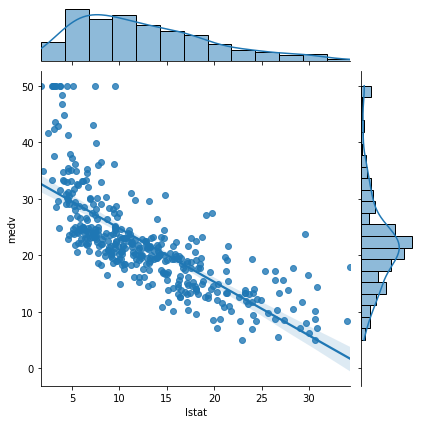

In [55]:
# Your plots here
sns.jointplot(data=MEDV,x="lstat", y="medv", kind="reg")

### What do these plots tell you about the relationships between these variables and the prices of homes in Boston? Are these the relationships you expected to see in these variables?

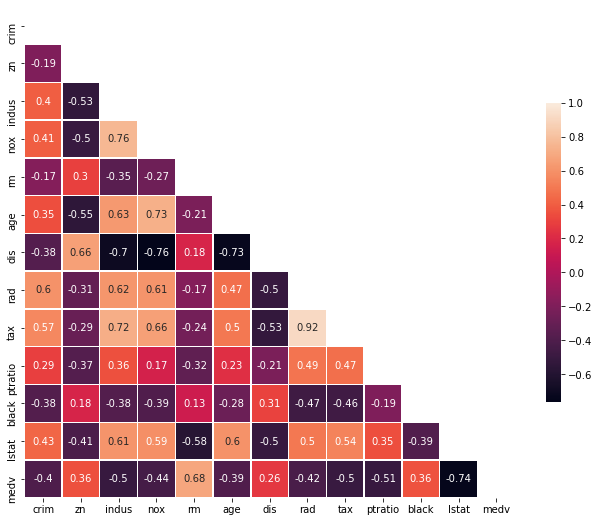

In [56]:
# Your response here
corr=boston.corr()
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True
f, ax = plt.subplots(figsize=(11, 11))
cmap = sns.diverging_palette(220, 10, as_cmap=True)
sns.heatmap(corr, mask=mask,  vmax=1,
            square=True, linewidths=.5, cbar_kws={"shrink": .5},annot = corr)
plt.show()

##indus and nox have very similar corrections to everything else.

### Make a heatmap of the remaining variables. Are there any variables that you did not consider that have very high correlations? What are they?

In [57]:
# Your response here

### Calculate Statistics
Calculate descriptive statistics for housing price. Include the minimum, maximum, mean, median, and standard deviation. 

In [58]:
# Your code here
boston.describe()

,crim,zn,indus,nox,rm,age,dis,rad,tax,ptratio,black,lstat,medv
count,404.000000,404.000000,404.000000,404.000000,404.00000,404.000000,404.000000,404.000000,404.000000,404.000000,404.000000,404.000000,404.000000
mean,3.730912,10.490099,11.189901,0.556710,6.30145,68.601733,3.799666,9.836634,411.688119,18.444554,355.068243,12.598936,22.312376
std,8.943922,22.037243,6.814909,0.117321,0.67583,28.066143,2.109916,8.834741,171.073553,2.150295,94.489572,6.925173,8.837019
min,0.006320,0.000000,0.460000,0.392000,3.56100,2.900000,1.169100,1.000000,187.000000,12.600000,0.320000,1.730000,5.000000
25%,0.082382,0.000000,5.190000,0.453000,5.90275,45.800000,2.087875,4.000000,281.000000,17.375000,374.710000,7.135000,17.100000
50%,0.253715,0.000000,9.795000,0.538000,6.23050,76.600000,3.207450,5.000000,330.000000,19.000000,391.065000,11.265000,21.400000
75%,4.053158,12.000000,18.100000,0.631000,6.62925,94.150000,5.222125,24.000000,666.000000,20.200000,396.007500,16.910000,25.000000
max,88.976200,95.000000,27.740000,0.871000,8.78000,100.000000,12.126500,24.000000,711.000000,22.000000,396.900000,34.370000,50.000000


----

## Developing a Model

### Implementation: Define a Performance Metric
What is the performance meteric with which you will determine the performance of your model? Create a function that calculates this performance metric, and then returns the score. 

In [59]:
from sklearn.metrics import r2_score

def performance_metric(y_true, y_predict):
    """ Calculates and returns the performance score between 
        true and predicted values based on the metric chosen. """
    # Your code here:
    return r2_score(y_true, y_predict)

### Implementation: Shuffle and Split Data
Split the data into the testing and training datasets. Shuffle the data as well to remove any bias in selecting the traing and test. 

In [60]:
# Your code here
from sklearn.model_selection import train_test_split
x = boston.drop('medv', axis = 1)
y = boston['medv']
x_train, x_test, y_train, y_test = train_test_split(x, y,random_state = 0, test_size = 0.2)

----

## Analyzing Model Performance
Next, we are going to build a Random Forest Regressor, and test its performance with several different parameter settings.

### Learning Curves
Lets build the different models. Set the max_depth parameter to 2, 4, 6, 8, and 10 respectively. 

In [61]:
# Five separate RFR here with the given max depths
# Five separate RFR here with the given max depths
from sklearn.ensemble import RandomForestRegressor

RFR_2              = RandomForestRegressor(n_estimators=100, max_depth=2,  random_state=15) 
RFR_4              = RandomForestRegressor(n_estimators=100, max_depth=4,  random_state=15) 
RFR_6              = RandomForestRegressor(n_estimators=100, max_depth=6,  random_state=15) 
RFR_8              = RandomForestRegressor(n_estimators=100, max_depth=8,  random_state=15) 
RFR_10             = RandomForestRegressor(n_estimators=100, max_depth=10, random_state=15) 

RFR_2_fitted       = RFR_2.fit(x_train, y_train)
RFR_4_fitted       = RFR_4.fit(x_train, y_train)
RFR_6_fitted       = RFR_6.fit(x_train, y_train)
RFR_8_fitted       = RFR_8.fit(x_train, y_train)
RFR_10_fitted      = RFR_10.fit(x_train, y_train)

y_RFR_2_predicted_test  = RFR_2_fitted.predict(x_test)
y_RFR_4_predicted_test  = RFR_4_fitted.predict(x_test)
y_RFR_6_predicted_test  = RFR_6_fitted.predict(x_test)
y_RFR_8_predicted_test  = RFR_8_fitted.predict(x_test)
y_RFR_10_predicted_test = RFR_10_fitted.predict(x_test)

pm_RFR_2_on_test_data  = performance_metric(y_test,y_RFR_2_predicted_test)
pm_RFR_4_on_test_data  = performance_metric(y_test,y_RFR_4_predicted_test)
pm_RFR_6_on_test_data  = performance_metric(y_test,y_RFR_6_predicted_test)
pm_RFR_8_on_test_data  = performance_metric(y_test,y_RFR_8_predicted_test)
pm_RFR_10_on_test_data = performance_metric(y_test,y_RFR_10_predicted_test)

y_RFR_2_predicted_train  = RFR_2_fitted.predict(x_train)
y_RFR_4_predicted_train  = RFR_4_fitted.predict(x_train)
y_RFR_6_predicted_train  = RFR_6_fitted.predict(x_train)
y_RFR_8_predicted_train  = RFR_8_fitted.predict(x_train)
y_RFR_10_predicted_train = RFR_10_fitted.predict(x_train)

pm_RFR_2_on_train_data  = performance_metric(y_train,y_RFR_2_predicted_train)
pm_RFR_4_on_train_data  = performance_metric(y_train,y_RFR_4_predicted_train)
pm_RFR_6_on_train_data  = performance_metric(y_train,y_RFR_6_predicted_train)
pm_RFR_8_on_train_data  = performance_metric(y_train,y_RFR_8_predicted_train)
pm_RFR_10_on_train_data = performance_metric(y_train,y_RFR_10_predicted_train)

print('Score | Depth = 2 | On Train =',pm_RFR_2_on_train_data, '| On Test= ',pm_RFR_2_on_test_data)
print('Score | Depth = 4 | On Train =',pm_RFR_4_on_train_data, '| On Test= ',pm_RFR_4_on_test_data)
print('Score | Depth = 6 | On Train =',pm_RFR_6_on_train_data, '| On Test= ',pm_RFR_6_on_test_data)
print('Score | Depth = 8 | On Train =',pm_RFR_8_on_train_data, '| On Test= ',pm_RFR_8_on_test_data)
print('Score | Depth = 10 | On Train =',pm_RFR_10_on_train_data, '| On Test= ',pm_RFR_10_on_test_data)

Score | Depth = 2 | On Train = 0.7750506850610402 | On Test=  0.7938994315269553
Score | Depth = 4 | On Train = 0.9090294210423104 | On Test=  0.8652256723946495
Score | Depth = 6 | On Train = 0.9527027757773129 | On Test=  0.8944234912418046
Score | Depth = 8 | On Train = 0.9684432490526975 | On Test=  0.9012887389249634
Score | Depth = 10 | On Train = 0.9734631448603268 | On Test=  0.9040020490348788


Now, plot the score for each tree on the training set and on the testing set.

In [62]:
# Produce a plot with the score for the testing and training for the different max depths

What do these results tell you about the effect of the depth of the trees on the performance of the model?

In [63]:
# Your response here

#### The higher the depth the more it overfits...
#### The higher the depth the more prediction power even though it stagnates.

### Bias-Variance Tradeoff
When the model is trained with a maximum depth of 1, does the model suffer from high bias or from high variance? How about when the model is trained with a maximum depth of 10? Check out this article before answering: https://towardsdatascience.com/understanding-the-bias-variance-tradeoff-165e6942b229

In [64]:
# Your response here

# # # Depth of 1 = High variance.
# # # Depth of 10 = High bias.

### Best-Guess Optimal Model
What is the max_depth parameter that you think would optimize the model? Run your model and explain its performance.

In [65]:
# Your response here
# Depth = 6.

### Applicability
*In a few sentences, discuss whether the constructed model should or should not be used in a real-world setting.*  
**Hint:** Some questions to answering:
- *How relevant today is data that was collected from 1978?*
- *Are the features present in the data sufficient to describe a home?*
- *Is the model robust enough to make consistent predictions?*
- *Would data collected in an urban city like Boston be applicable in a rural city?*

In [66]:
# Your response here

# 1978 -> Not relevant at all.
# A lot is missing, but or model is on with a 90% accuracy on test data anyway.
# I think 90% is pretty bad nowadays for predicting pricing...